In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import random
import inspect
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../data/text-1.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower().replace('\n', ' ')

In [3]:
chars = sorted(set(text))

In [100]:
char2int = {c:i for i,c in enumerate(chars)}
# sot = '>'
# assert sot not in char2int
# char2int[sot] = 0
int2char = {i:c for c,i in char2int.items()}
numOfTokens = len(char2int)
print(f'{numOfTokens=}')
textInt = [char2int[ch] for ch in text]

numOfTokens=74


In [296]:
ctxLen = 10
def getSamples(trSamplNum=10, valSampleNum=None):
    # random.seed(123)
    valSampleNum = int(trSamplNum*0.3) if valSampleNum == None else valSampleNum
    idxs = random.sample(range(0,len(text)-ctxLen), trSamplNum+valSampleNum)
    X,Y = [],[]
    for i in idxs:
        X.append(textInt[i:i+ctxLen])
        Y.append(textInt[i+1:i+1+ctxLen])
    Xtr,Ytr = torch.tensor(X[:trSamplNum]), torch.tensor(Y[:trSamplNum])
    Xval,Yval = torch.tensor(X[trSamplNum:]), torch.tensor(Y[trSamplNum:])
    return ( Xtr,Ytr, Xval,Yval, )

In [662]:
def print2dEmb(embLayer):
    W = embLayer.weight
    plt.figure(figsize=(8,8))
    plt.scatter(W[:,0].data,W[:,1].data,s=200)
    for i in range(W.shape[0]):
        plt.text(W[i,0].item(), W[i,1].item(), int2char[i], ha="center", va="center", color='white')
    plt.grid('minor')

def showParamsStats(model, layerNameFilter=None):
    plt.figure(figsize=(20,4))
    legends = []
    for pName, pValue in model.named_parameters():
        if layerNameFilter == None or layerNameFilter.match(pName):
            print(f'layer \'{pName}\'[{pValue.nelement()}] mean:{pValue.mean()}, std:{pValue.std()},')
            hy,hx = torch.histogram(pValue, density=True)
            plt.plot(hx[:-1].detach(),hy.detach(),)
            legends.append(pName)
    plt.legend(legends);

def showParamsStats2(model, layerNameFilter=None, figsize=(20,10)):
    params = [
        (pName, pValue)
        for pName, pValue in model.named_parameters()
        if layerNameFilter == None or layerNameFilter.match(pName)
    ]
    _,axs = plt.subplots(len(params),1, figsize=figsize)
    # _,axs = plt.subplots(len(params),1)
    for i, (pName, pValue) in enumerate(params):
        # print(f'layer \'{pName}\'[{pValue.nelement()}] mean:{pValue.mean()}, std:{pValue.std()},')
        hy,hx = torch.histogram(pValue, density=False)
        axs[i].plot(hx[:-1].detach(),hy.detach(), label=f'{pName}({pValue.nelement()}) mean:{pValue.mean():.4f}, std:{pValue.std():.4f}')
        # axs[i].set_title(f'{pName}({pValue.nelement()}) mean:{pValue.mean():.4f}, std:{pValue.std():.4f},')
        axs[i].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0)) # bbox_to_anchor=(0.0, 0.0)
    plt.tight_layout()
    

In [475]:
def fillInPlace(tensor,value):
    tensor.requires_grad = False
    tensor.fill_(value)
    tensor.requires_grad = True

In [676]:
class MlpPredictor(nn.Module):
    def __init__(self,numOfTokens,ctxLen,embSize):
        super().__init__()
        self.ctxLen = ctxLen
        self.embSize = embSize
        self.emb = nn.Embedding(numOfTokens,embSize)
        hidDim1 = 1000
        hidDim2 = 1000
        hidDim3 = 1000
        hidDim4 = 1000
        self.lin1 = nn.Linear(ctxLen*embSize,hidDim1)
        self.lin2 = nn.Linear(hidDim1,hidDim2)
        self.lin3 = nn.Linear(hidDim2,hidDim3)
        self.lin4 = nn.Linear(hidDim3,hidDim4)
        self.lin5 = nn.Linear(hidDim4,ctxLen*numOfTokens)

        # fillInPlace(self.emb.weight, -1)

        # fillInPlace(self.lin1.weight, 1)
        # fillInPlace(self.lin2.weight, 1)
        # fillInPlace(self.lin3.weight, 1)
        # fillInPlace(self.lin4.weight, 1)
        # fillInPlace(self.lin5.weight, 1)
        
        # fillInPlace(self.lin1.bias, 0)
        # fillInPlace(self.lin2.bias, 0)
        # fillInPlace(self.lin3.bias, 0)
        # fillInPlace(self.lin4.bias, 0)
        # fillInPlace(self.lin5.bias, 0)
    def forward(self,x):
        x = self.emb(x).view(-1,self.ctxLen*self.embSize)

        x = self.lin1(x)
        x = F.leaky_relu(x)
        r1 = x

        x = self.lin2(x)
        x = F.leaky_relu(x)
        r2 = x

        x = self.lin3(x+r1)
        x = F.leaky_relu(x)
        r3 = x

        x = self.lin4(x+r2)
        x = F.leaky_relu(x)

        x = self.lin5(x+r3)
        
        x = x.view(-1,ctxLen,numOfTokens)
        return x
    @torch.no_grad()
    def generate(self,ctx,resLen):
        if len(ctx) < self.ctxLen:
            ctx = ' '*(ctxLen-len(ctx)) + ctx
        elif len(ctx) > self.ctxLen:
            ctx = ctx[-ctxLen:]
        res = []
        while len(res) < resLen:
            x = torch.tensor([char2int[ch] for ch in ctx]).unsqueeze(0)
            logits = self(x)[0,-1]
            probs = F.softmax(logits,dim=0)
            nextToken = torch.multinomial(probs, 1)
            nextChar = int2char[nextToken[0].item()]
            res.append(nextChar)
            ctx = ctx[1:] + nextChar
        return ''.join(res)

In [677]:
model = MlpPredictor(numOfTokens=numOfTokens,ctxLen=ctxLen,embSize=32)

In [660]:
def calcLoss(model,X,Y):
    Yp = model(X)
    logits = Yp.view(-1,numOfTokens)
    targets = Y.view(-1)
    return F.cross_entropy(logits,targets)

numOfParams=6188588


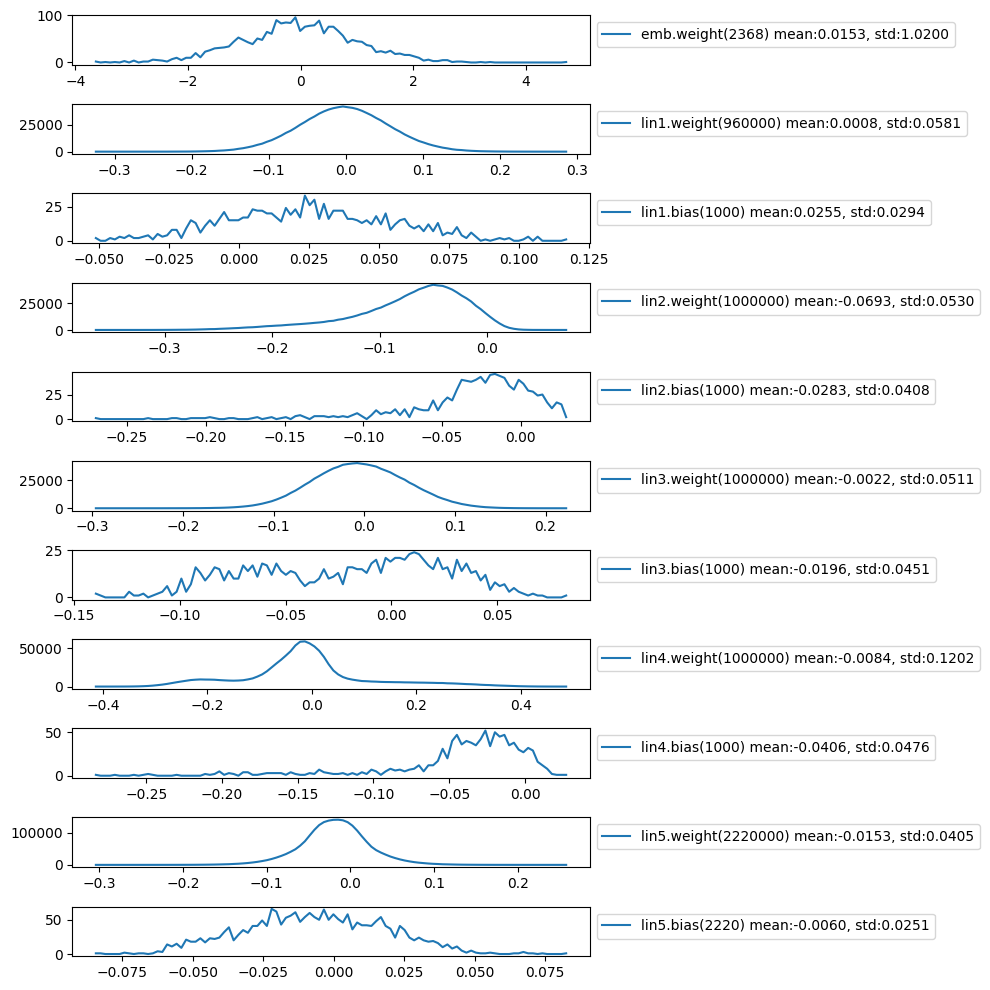

In [700]:
numOfParams = sum(p.nelement() for p in model.parameters())
print(f'{numOfParams=}')
# showParamsStats2(model,layerNameFilter=re.compile('^lin.*weight$'))
showParamsStats2(model, figsize=(10,10))

In [699]:
model.generate('',100)

'hom and of nouthe by thes mong themand to tis uut” ss feler aflat oa mereand tos ar cered, thalcanta'

In [701]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [703]:
epochsNum = 100
batchesPerEpoch = 100
batchSize = 128

for epoch in range(epochsNum):
    # paramsBeforeEpoch = [(n,p.clone()) for n,p in model.named_parameters()]

    Xtr,Ytr, Xval,Yval = getSamples(trSamplNum=batchesPerEpoch*batchSize)
    batchIdxs = [i for i in range(len(Xtr))[::batchSize]]
    random.shuffle(batchIdxs)
    for batch_begin in batchIdxs:
        batch_end = batch_begin+batchSize
        Xb = Xtr[batch_begin:batch_end]
        Yb = Ytr[batch_begin:batch_end]
        loss = calcLoss(model,Xb,Yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        trLoss = calcLoss(model,Xtr,Ytr)
        valLoss = calcLoss(model,Xval,Yval)
        # meanAbsParamDiff = [
        #     (name, (before-after).abs().mean().item()) 
        #     for ((name,before),after) in zip(paramsBeforeEpoch,[p for _,p in model.named_parameters()])
        # ]
        # meanAbsParamDiffStr = ';\n\t'.join([f'{name}={diff:.4f}' for name,diff in meanAbsParamDiff])
        # print(f'epoch:{epoch}, trLoss={trLoss.item():.4f}, valLoss={valLoss.item():.4f},\n\tparamDiff:\n\t{meanAbsParamDiffStr}')
        print(f'epoch:{epoch}, trLoss={trLoss.item():.4f}, valLoss={valLoss.item():.4f}')

epoch:0, trLoss=0.0847, valLoss=0.0861
epoch:1, trLoss=0.0855, valLoss=0.0894
epoch:2, trLoss=0.0865, valLoss=0.0857
epoch:3, trLoss=0.0847, valLoss=0.0857
epoch:4, trLoss=0.0842, valLoss=0.0860


KeyboardInterrupt: 